<a href="https://colab.research.google.com/github/Tancp123/DLI_indi/blob/main/Detecting_Android_Malware_from_App_Permissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
saurabhshahane_android_permission_dataset_path = kagglehub.dataset_download('saurabhshahane/android-permission-dataset')

print('Data source import complete.')


Data source import complete.


# Detecting Android Malware based on App Permissions

![scanning_malware_header.jpg](attachment:7a646938-b250-431e-9e5b-1f78332a6baf.jpg)

# Intro and Motivation

Android has supported multiple 3rd-party app stores for years, and a recent court ruling will soon force Apple to support this too, giving users more choices.  Yet at the same time, an argument can be made that 3rd-party app stores can contain more malware or nefarious apps due to less strict vetting.

Whether this is true or just hyperbole, it would serve smartphone users if an app could be predicted as malware or benign before downloading it, based just on the permissions that the app requests (e.g. needs access to pictures and media, or your microphone, etc.).

In this notebook, we'll explore such a dataset and see if Android apps can be properly classified based on permissions alone.  Let's get to it!

# Dataset Background

I found a tabular dataset on Kaggle that has about 30,000 apps classified as malware or benign, as well as the permissions they require.  

The dataset contains other data like: app title, description, number of reviews, star review rating, and price, that can be gathered from the Google Play store, but I wanted to design a classifier that would be based purely on permissions.  Honestly, the star rating and the description would probably be quite informative since scams usually have poor grammar or overuse scammy words, but I wanted this to work "in a vacuum" and based on just finding a binary (.apk file) anywhere.  After all, it should still be useful for the first person who downloads it from the app store.  

The list of requested permissions came from a tool called Apk Analyzer, but that's not super important for our purposes.

It consists of 184 columns of data, which includes: `class label, app title, package name, category, description, rating, number of reviews, price, and related apps`.  We'll delete all these just listed for the sake of classifying, so that leaves 184 - 9 = 175 actual features used for training and inference.

All of these appear to be binary flags except for: `Dangerous permissions count` and `Safe permissions count`, which are of course both integers.  But we'll confirm this in our data analysis.  I initially wanted to include `Dangerous permissions count` and `Safe permissions count` as features, but the problem with that is, what might be Dangerous or Safe seems subjective and was created by whoever made this dataset.  It would be introducing that person's bias *a priori* into the dataset, which isn't good practice.  Secondly, if we get new Android apps submitted to our fictitious virus scanner, it won't have those features.  The only data that Apk Analyzer will give is the raw boolean permission flags.  So we'll drop these too and end up with 173 total features &mdash; purely the permission flags.

There are 29,999 total apps in the dataset.  According to Kaggle, 20,000 are malware and 9,999 are benign, but we'll also confirm this ourselves.

# Data Exploration

Let's start with looking at the data we're dealing with, always a good idea.

In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [96]:
# Read in the Pandas DataFrame
malware_pdf = pd.read_csv("/kaggle/input/android-permission-dataset/Android_Permission.csv")

# Look at the head of it
malware_pdf.head()

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.00,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,...,0,1,0,0,0,0,0,1,0,0
1,Word Farm,com.realcasualgames.words,Brain & Puzzle,Speed and strategy combine in this exciting wo...,4.3,199,0.00,"{air.com.zubawing.FastWordLite, com.joybits.do...",3.0,2,...,0,0,0,0,0,0,0,0,0,0
2,Fortunes of War FREE,fortunesofwar.free,Cards & Casino,"Fortunes of War is a fast-paced, easy to learn...",4.1,243,0.00,"{com.kevinquan.condado, hu.monsta.pazaak, net....",1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,Better Keyboard: Avatar Purple,com.cc.betterkeyboard.skins.avatarpurple,Libraries & Demo,Skin for Better Keyboard featuring a glossy fe...,3.6,2589,0.00,{eu.gdumoulin.betterandroid.skins.transparent....,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boxing Day,indiaNIC.android.BoxingDay,Lifestyle,Boxing Day by Christopher Jaymes<p>Based on a ...,0.0,0,5.99,NaN,1.0,0,...,0,0,0,0,0,0,0,0,0,1


In [97]:
malware_pdf.columns

Index(['App', 'Package', 'Category', 'Description', 'Rating',
       'Number of ratings', 'Price', 'Related apps',
       'Dangerous permissions count', 'Safe permissions count',
       ...
       'Your personal information : read calendar events (D)',
       'Your personal information : read contact data (D)',
       'Your personal information : read sensitive log data (D)',
       'Your personal information : read user defined dictionary (D)',
       'Your personal information : retrieve system internal state (S)',
       'Your personal information : set alarm in alarm clock (S)',
       'Your personal information : write Browser's history and bookmarks (D)',
       'Your personal information : write contact data (D)',
       'Your personal information : write to user defined dictionary (S)',
       'Class'],
      dtype='object', length=184)

We see the previously-mentioned columns we named before, that we plan to drop, and a long truncated list of app permissions.

In [98]:
malware_pdf.shape

(29999, 184)

This matches what Kaggle says about this dataset: 29,999 data entries (not including headers) and 184 columns each, 11 of which we won't use.

In [99]:
# Get a quick description of the dataset

# Set this to True initially to see all the datatypes and see if any missing values,
# then turned it off because it's so long

# malware_pdf.info(verbose=True, show_counts=True)
malware_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Columns: 184 entries, App to Class
dtypes: float64(3), int64(176), object(5)
memory usage: 42.1+ MB


Confirmed that all the features we're interested in, which are just the permission flags, are integers and none have missing values.  We'll do some further data validating soon, since it's not a good idea to just look manually when there are so many columns - it's too easy to miss something.

## Drop Features We Won't Use

In [100]:
# Drop all the columns we don't care about
malware_pdf = malware_pdf.drop('App', axis=1)
malware_pdf = malware_pdf.drop('Package', axis=1)
malware_pdf = malware_pdf.drop('Category', axis=1)
malware_pdf = malware_pdf.drop('Description', axis=1)
malware_pdf = malware_pdf.drop('Rating', axis=1)
malware_pdf = malware_pdf.drop('Number of ratings', axis=1)
malware_pdf = malware_pdf.drop('Price', axis=1)
malware_pdf = malware_pdf.drop('Related apps', axis=1)
malware_pdf = malware_pdf.drop('Dangerous permissions count', axis=1)
malware_pdf = malware_pdf.drop('Safe permissions count', axis=1)

malware_pdf.shape

(29999, 174)

Matches the dimensions we discussed earlier, except the one extra column (we said earlier we should have 173 features) is we still have the `Class Labels` in this data.

## Check for Null or NA data

In [101]:
# See how much of remaining data is null
malware_pdf.isnull().sum()

,0
Default : Access DRM content. (S),0
Default : Access Email provider data (S),0
Default : Access all system downloads (S),0
Default : Access download manager. (S),0
Default : Advanced download manager functions. (S),0
...,...
Your personal information : set alarm in alarm clock (S),0
Your personal information : write Browser's history and bookmarks (D),0
Your personal information : write contact data (D),0
Your personal information : write to user defined dictionary (S),0


In [102]:
# Don't think any of the remaining data has null or missing values,
# so let's just drop any rows that have na
malware_pdf = malware_pdf.dropna()
malware_pdf.shape

(29999, 174)

We can see nothing was dropped, which confirms that, by this point, the features and the labels are all clean.

## Useful Columns

Let's see if we can condense any of the data by looking for features which don't seem to apply to any or many of the apps.  For example, if none of the apps use Permission X, then it is not going to have any predictive value and can be dropped from out dataset.  Even if only a few apps have it, it probably won't be enough to be statistically significant.

In [103]:
# Based on our sample size of only 29,999 apps, our margin of error is 0.6%
# (margin of error in percent = 100 / sqrt(N)) ==> 100 / sqrt(29999)
# And 0.6% of 29,999 apps is 180 apps.  So if less than 180 apps have a
# feature, it's less than our margin of error and statistically insignificant,
# so we'll drop those permission columns.
PERM_THRESHOLD = 180             # Number of apps which must have a certain permission to keep it
NUM_APPS = malware_pdf.shape[0]  # 29,999

too_few_col_dropper = []    # We'll store column headers to be dropped in this list.  These are permissions that not many apps have
too_many_col_dropper = []   # Too many apps have these permissions for predictive value

# value_counts() returns a Pandas series, where the 0 key counts how many did not
# have the feature, and 1 counts how many that did.

# Note that if none had the feature, then the 1 key will not be present,
# and we get a key error.  We could check for the 0 case is 29999, but
# I think that's a bit kludgy.  Thankfully, Pandas series supports the
# .get() method, which can return a default value if key error.

# p.s. Don't look at the last column, which is the class label
for col in malware_pdf.columns[:-1]:
    # If the value count key is not found, there are 0 counts
    if (malware_pdf[col].value_counts().get(1, 0) < PERM_THRESHOLD):
        too_few_col_dropper.append(col)

print(f"There are {len(too_few_col_dropper)} permissions that less than {PERM_THRESHOLD} apps have, and will therefore be dropped.")

# Similarly, are there any permissions that almost ALL apps have (unlikely),
# that also gives them little predictive value.
for col in malware_pdf.columns[:-1]:
    # If the value count key is not found, there are 0 counts
    if (malware_pdf[col].value_counts().get(1, 0) > (NUM_APPS - PERM_THRESHOLD)):
        too_many_col_dropper.append(col)

# Turns out none fit this bill, but that's OK - code is reusable
print(f"There are {len(too_many_col_dropper)} permissions that more than than {NUM_APPS - PERM_THRESHOLD} apps have, and will therefore be dropped.")

# Drop the columns
malware_pdf = malware_pdf.drop(malware_pdf[too_few_col_dropper], axis=1)
malware_pdf = malware_pdf.drop(malware_pdf[too_many_col_dropper], axis=1)
malware_pdf.shape

There are 122 permissions that less than 180 apps have, and will therefore be dropped.
There are 0 permissions that more than than 29819 apps have, and will therefore be dropped.


(29999, 52)

Out of the original 173 possible permissions, only 52 permissions are left that are statistically significant.  This will speed up training significantly, as the data is about one third the size it was before!

## Visualization

In [104]:
# For some visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
malware_pdf['Class'].value_counts()

,count
Class,
1,20000
0,9999


<Axes: xlabel='Class', ylabel='count'>

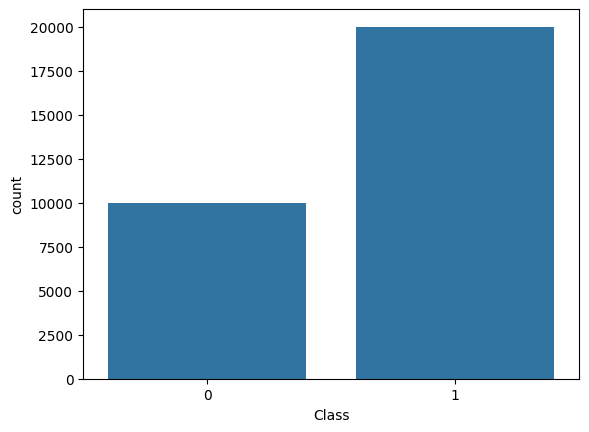

In [106]:
sns.countplot(data=malware_pdf, x='Class')

We can see it's an imbalanced dataset, with the malware class existing about 2:1 ratio to the benign class.  Not a crazy imbalance, but it will still cause our model to tend to identify more apps as malware than are.  We'll want to look not at accuracy (which assumes a balanced dataset), but instead we'll look at the confusion matrix (for skewed datasets) and we'll take a look at the Precision-Recall curve.

# Split and Prepare Data for Training

In [107]:
from sklearn.model_selection import train_test_split

# First let's get the class labels
y = malware_pdf['Class']

# And drop them from X (which loses the column headers)
X = malware_pdf.drop(['Class'], axis=1)

# Convert y labels to NumPy array for learning
y = np.array(y)

print(f"X: {X.shape} of type {type(X)}")
print(f"y: {y.shape} of type {type(y)}")

X: (29999, 51) of type <class 'pandas.core.frame.DataFrame'>
y: (29999,) of type <class 'numpy.ndarray'>


In [108]:
# NOTE: Don't need to standardize/normalize the features, they're all already on the same small scale

# Split the data.  Let's do a 80/10/10 split for train/val/test
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42)        # 20% goes to temp variable
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)  # which is then split in half to make val and test sets

# Try adding a dimension here to fix training issue, not learning.  ==>  Wasn't an issue, dropping this.
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# Confirm sizes and types.  Note that all X are converted to NumPy ndarrays!
print(f"X_train: {X_train.shape} of type {type(X_train)}")
print(f"y_train: {y_train.shape} of type {type(y_train)}\n")

print(f"X_val: {X_val.shape} of type {type(X_val)}")
print(f"y_val: {y_val.shape} of type {type(y_val)}\n")

print(f"X_test: {X_test.shape} of type {type(X_test)}")
print(f"y_test: {y_test.shape} of type {type(y_test)}\n")

X_train: (23999, 51) of type <class 'pandas.core.frame.DataFrame'>
y_train: (23999,) of type <class 'numpy.ndarray'>

X_val: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_val: (3000,) of type <class 'numpy.ndarray'>

X_test: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_test: (3000,) of type <class 'numpy.ndarray'>



# Baseline Neural Network Model

Let's use a neural network as a baseline and compare some different architectures to that.

In [109]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))  # Not using the GPU here, not necessary with such a small dataset

2.19.0
[]


In [110]:
input_size = X_train.shape[1]  # num. features

# Define a bunch of metrics for all neural network models
# 'Accuracy' not very relevant for imbalanced datasets
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.BinaryCrossentropy(name="binary cross entropy"),   # same as model's loss
    'accuracy'                                                          # just for the heck of it
]

# Started with a plain jane neural network and made it slightly more fancy after several design iterations

leaky_relu = tf.keras.layers.LeakyReLU()  # Prevent dead neurons

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation=leaky_relu, kernel_initializer="he_normal", input_shape=(input_size,)),
    # tf.keras.layers.BatchNormalization(),  # Not deep enough, where Dropout helped more.  Using both together has some issues to watch for.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=leaky_relu, kernel_initializer="he_normal"),  # He initialization recommended for Leaky ReLU
    # tf.keras.layers.BatchNormalization(),  # Not deep enough, where Dropout helped more.  Using both together has some issues to watch for.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation=leaky_relu, kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation=leaky_relu, kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary cross entropy.  For sigmoid, keep the default Glorot initialization
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.005)  # Found through experimentation below
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
baseline_model = model
baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,121 (1.67 MB)

 Trainable params: 437,121 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

> 📝 **NOTE:** The following code we already know will have some problems, as we noted this class is imbalanced.  So looking at the accuracy will make the neural net tend to set its weights to prefer the over-represented class!  Let's confirm that.

## Find Max Learning Rate

In the next code block, which I've commented out now, we use a *growing* learning rate and increase the learning rate upon each epoch.  We then plot the loss and see where it starts to oscillate and explode.  We are trying to find out the largest learning rate we can use *for this dataset* where learning is still stable, to minimize training time.

If you uncomment the following code, you'll find that the last stable learning occurred around epoch 11, when the learning rate was 0.0102.  Good practice is to start with half of this as the initial learning rate, and slowly reduce this as training continues.  So we'll start with an initial learning rate of 0.005.

In [112]:
# # First let's try a GROWING learning rate to find the optimal starting learning rate

# # For finding last stable learning rate.
# # Let's try to grow the learning rate at each iteration (use exponential learning rate)
# expon_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-5 * 2**(epoch / 1))  # Making this 2x every epoch to accelerate the curve

# history = baseline_model.fit(X_train,
#                     y_train,
#                     batch_size=512,
#                     epochs=20,
#                     callbacks=[expon_lr],           # Make the learning rate grow after each epoch to find instability point (see when loss blows up)
#                     validation_data=(X_val, y_val)
#                    )

# # Plot the loss and accuracy curves for training and validation
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

## Training the NN

I like the `ReduceLROnPlateau` callback because, rather than always slowly reducing the learning rate (which slows overall training), we can instead only reduce it if the validation loss goes for too long without improving.  This helps overall training be faster.  Let's try that, in conjunction with the EarlyStopping callback to stop the training when learning is no longer progressing, even with the smaller learning rates.

In [113]:
import tensorflow as tf
import numpy as np

BATCH_SIZE = 512    # In general, the larger the class imbalance, the larger you need these batch sizes to be
                    # Otherwise, the chances decrease that a batch has examples from each class to learn from.
                    # This is really more of a problem for like, fraudulent transactions or anomaly detection,
                    # where the positive class might be like 0.01% of the time or something.
                    # Still, good practice to make this bigger than we would've otherwise, and class imbalance isn't terrible here.

early_stopping_patience = 9
reduce_lr_on_plateau_patience = 5

# Ensure that plateau patience is less than early stopping, or training will end before we can reduce learning rate!
assert reduce_lr_on_plateau_patience < early_stopping_patience  # Break the code if my assumption isn't right!

# Stop if learning hasn't happened in so many epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

# But first, reduce the learning rate if learning hasn't happened in a shorter number of epochs
# Halve the learning rate only if we go some epochs without improving
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=reduce_lr_on_plateau_patience)

# Fix the shape mismatch - reshape y_train and y_val to match model output
y_train_reshaped = y_train.reshape(-1, 1)  # Convert from (n,) to (n, 1)
y_val_reshaped = y_val.reshape(-1, 1)      # Convert from (n,) to (n, 1)

history = baseline_model.fit(X_train,
                    y_train_reshaped,  # Use reshaped labels
                    batch_size=BATCH_SIZE,
                    epochs=1000,                     # Early Stopping will happen much sooner, set high to always be stopped by early stopping
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                    validation_data=(X_val, y_val_reshaped),  # Use reshaped validation labels
                    verbose=1
                   )

Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5984 - binary cross entropy: 0.9204 - fn: 1655.0625 - fp: 3184.6250 - loss: 0.9204 - precision: 0.6743 - recall: 0.7623 - tn: 1004.1042 - tp: 6686.8335 - val_accuracy: 0.6730 - val_binary cross entropy: 0.6144 - val_fn: 36.0000 - val_fp: 945.0000 - val_loss: 0.6144 - val_precision: 0.6747 - val_recall: 0.9820 - val_tn: 59.0000 - val_tp: 1960.0000 - learning_rate: 0.0050
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6453 - binary cross entropy: 0.6485 - fn: 963.0000 - fp: 3464.0208 - loss: 0.6485 - precision: 0.6803 - recall: 0.8790 - tn: 732.0000 - tp: 7371.6040 - val_accuracy: 0.6683 - val_binary cross entropy: 0.6108 - val_fn: 48.0000 - val_fp: 947.0000 - val_loss: 0.6108 - val_precision: 0.6729 - val_recall: 0.9760 - val_tn: 57.0000 - val_tp: 1948.0000 - learning_rate: 0.0050
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6599 - binary cross entropy: 0.6297 - fn: 708.7917 - fp

We've used `restore_best_weights`, so we need to look at the line with the lowest validation loss.  (NOTE: these exact numbers below might be a little different than above due to some non-determinism)

## Learning Curves

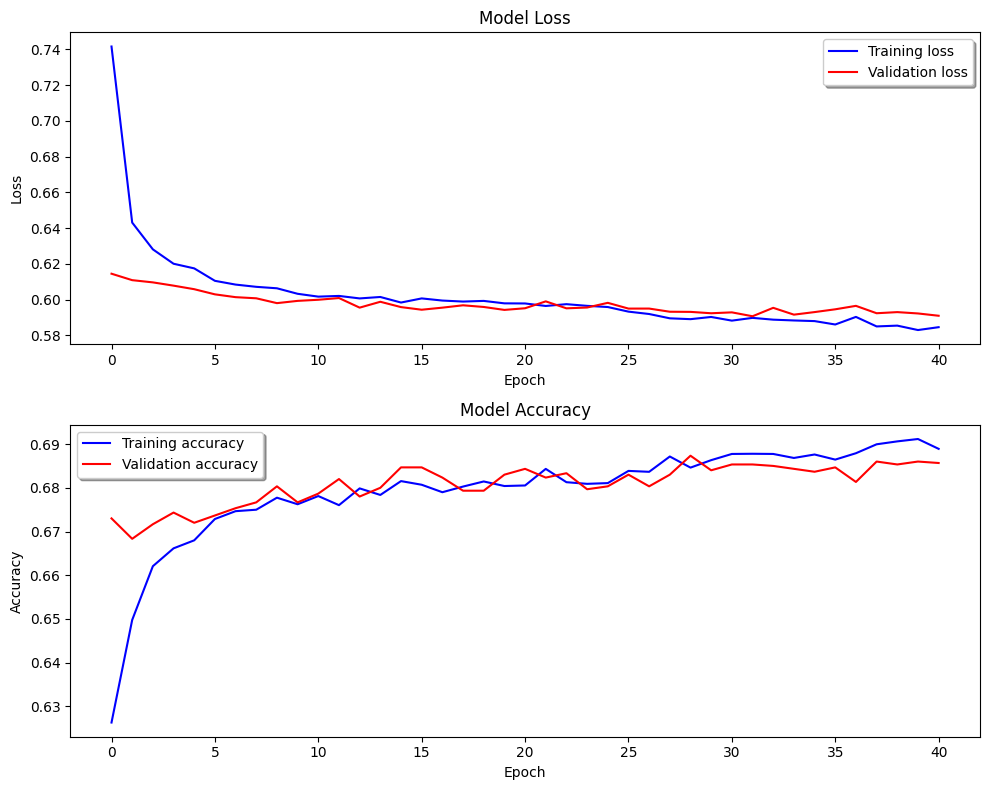

In [114]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")  # Removed axes parameter
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
legend = ax[0].legend(loc='best', shadow=True)

# Plot accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
legend = ax[1].legend(loc='best', shadow=True)

plt.tight_layout()  # Prevents overlapping of subplots
plt.show()

Here we can see that with our imbalanced class, the model wants to converge such that the positive class accuracy follows the representation of that class in the data, or here we have a 2:1 positive-to-negative class ratio, or 2/3, and the model wants to follow close to that accuracy, which explains why this model is not learning well.  For example, the accuracy is about 0.68 which is similar to 66.6%.

In this case, we have a Precision of 0.692, meaning 69.2% of apps we flag as malware is actually malware.  We have a Recall of 0.941, meaning that we correctly catch 94.1% of all actual malware.  However, we're still flagging 836 apps in our validation set as malware that are not (out of 3000 apps), meaning about 27% of apps are falsely flagged as malware, which is pretty bad.

What can we do about it?

## `class_weight` Argument
Actually, now Keras can directly handle imbalanced classes by using a class_weight argument.  We calculate these weights below, and they cause the model to "pay more attention" to examples from underrepresented classes by giving them larger weights.  This does not give our model any additional information or data, it's more equivalent to changing the decision threshold.  It works under the hood by giving a larger penalty to the loss for misclassified examples in the minority class, to try to compensate.  It makes these errors more expensive.

> 📝 **NOTE:** I commented out the following `class_weight` experiment.  It doesn't fix the problem, and on the learning curves, saw performance was actually worse.

In [115]:
# # Calculate the weights
# weight_for_0 = 1.0 / malware_pdf['Class'].value_counts()[0]
# weight_for_1 = 1.0 / malware_pdf['Class'].value_counts()[1]

# print(f"Weight for 0 class: {weight_for_0}")  # 1.0 / 9,999  = 0.00010001
# print(f"Weight for 1 class: {weight_for_1}")  # 1.0 / 20,000 = 0.00005

# # We can scale them by total/2 which will keep the overall relative ratios the same,
# # but this helps keep our loss to a similar magnitude as without using weights.
# total = malware_pdf['Class'].value_counts()[0] + malware_pdf['Class'].value_counts()[1]
# weight_for_0 *= (total / 2.0)
# weight_for_1 *= (total / 2.0)

# print(f"Weight for 0 class: {weight_for_0}")  # 1.5
# print(f"Weight for 1 class: {weight_for_1}")  # 0.75

# class_weight = {0: weight_for_0, 1: weight_for_1}

In [116]:
# # Add the class_weights and compare
# history = baseline_model.fit(X_train,
#                     y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=1000,                     # Early Stopping will happen much sooner, set high to always be stopped by early stopping
#                     callbacks=[early_stopping],
#                     validation_data=(X_val, y_val),
#                     class_weight=class_weight         # Here is where the imbalanced classes is handled
#                    )

# # Need these for plotting
# train_predictions_weighted = baseline_model.predict(X_train, batch_size=BATCH_SIZE)
# val_predictions_weighted = baseline_model.predict(X_val, batch_size=BATCH_SIZE)
# test_predictions_weighted = baseline_model.predict(X_test, batch_size=BATCH_SIZE)

In [117]:
# # Plot the loss and accuracy curves for training and validation
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

⚠ As mentioned earlier, playing with the class weights has only really pushed the decision threshold around.  Due to the Precision-Recall tradeoff, this model isn't really "better" necessarily, we need to decide which is better for this application.  For example, with this higher precision model, we are more confident that if we flag something as malware, it actually is.  However, this came with sweeping in many more apps being flagged as malware that aren't.

## Oversampling

One other thing we could do to deal with skewed datasets is to try to unskew them.  You can try to undersample, which means deleting data from your dataset that is over-represented.  This is a good idea when you have tons of data (hundreds of thousands to millions of data points).  But in our case where we only have tens of thousands of datapoints anyway, this is undesirable.  We'd be getting rid of half of our malware examples!

For cases where you don't have lots of data, you can try oversampling, which means adding copies of under-represented instances to the dataset.  This can sometimes help training, but it's similar to weighting the classes during learning in that it's not magic &mdash; we don't have any real additional data.  As we'll see shortly, we can essentially get mostly around the skewed data issue by looking at F1-Score instead of Accuracy.

You could also try using an algorithm like [SMOTE](https://arxiv.org/abs/1106.1813), which synthetically generates new data based on existing examples in your dataset.  They're not *exactly* the same, but have some random variation.

In the end, I think a 2:1 ratio is not actually that imbalanced, and looking at F1-Score instead of Accuracy gives us a decent way to deal with it.

## Confusion Matrix

💡 Let's plot the confusion matrix, which is a helpful way to evaluate the performance of a classifier.

It provides a summary of the predictions made by a model as compared to the ground truth labels.

loss :  0.5972740650177002
compile_metrics :  79.0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Legitimate Benign Apps Detected (True Negatives):  109
Legitimate Benign Apps Incorrectly Detected (False Positives):  880
Malicious Apps Missed (False Negatives):  79
Malicious Apps Detected (True Positives):  1932
Total Malicious Apps:  2011


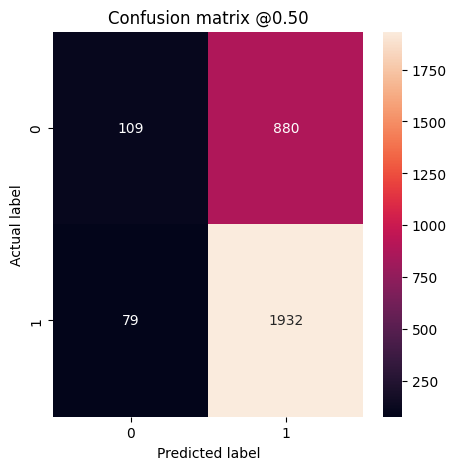

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Benign Apps Detected (True Negatives): ', cm[0][0])
    print('Legitimate Benign Apps Incorrectly Detected (False Positives): ', cm[0][1])
    print('Malicious Apps Missed (False Negatives): ', cm[1][0])
    print('Malicious Apps Detected (True Positives): ', cm[1][1])
    print('Total Malicious Apps: ', np.sum(cm[1]))

# Reshape y_test to match the model's expected output shape
y_test_reshaped = y_test.reshape(-1, 1)

# Get the baseline results for the original model (without the class weights)
baseline_results = baseline_model.evaluate(X_test, y_test_reshaped, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(baseline_model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

# Get predictions for the Confusion Matrix
test_predictions_baseline = baseline_model.predict(X_test, batch_size=BATCH_SIZE)

# For confusion matrix, we need 1D arrays, so flatten the predictions and use original y_test
test_predictions_baseline_flat = test_predictions_baseline.flatten()

# Use original y_test (1D) for confusion matrix since sklearn expects 1D arrays
plot_cm(y_test, test_predictions_baseline_flat)

plt.show()

The top row is for the ground truth equal to 0, or samples that are actually benign.
The second row contains examples where the ground truth was 1, or malware samples.

The leftmost column contains examples that were predicted to be benign.
The rightmost column contains examples that were predicted to be malware.

Therefore the top-left quadrant is called `true negatives`, benign apps that were classified accurately.
The bottom-right quadrant contains `true positives`, malware apps that were classified accurately.

The top-right quadrant contains app examples that were actually benign but were labeled by our classifier as malware.  These are called `false positives`.
Similarly, the bottom left quadrant is apps that were actually malware but were labeled as benign.  These are called `false negatives`.

Ideally, the confusion matrix would only contain examples along the diagonal, with the off-diagonal entries being 0.  But this is real-world data and so that never is the case for non-trivial problems.

Our classifier outputs predictions, which are probabilities.  In other words, a 0.99 is very certain this is malware, where a probability of 0.01 is very certain to be benign.  But we can compare these probabilities to a certain threshold (default of 0.5 in the confusion matrix above) to allow us to tweak the `precision` or `recall` best for our use case.  What are precision and recall?  Please see my other notebook [What Kaggle WON'T Tell You About Your Notebooks](https://www.kaggle.com/code/quackaddict7/what-kaggle-won-t-tell-you-about-your-notebooks/notebook#Precision-and-Recall), where I explain these terms intuitively and in-depth.

Well, so which do we actually want for our made-up virus scanner?  If we have a high recall (low precision), then we capture more of the true positives.  In other words, we'll have a low number of false negatives (malware apps incorrectly flagged as safe).  This is desired.  But we'll also then have a higher number of false positives (benign apps flagged as malware).  For a virus scanner, it'd be better to have more false positives (so, high recall and low precision).  In other words, a LOWER threshold.  But if there are too many false positives, this will annoy users, keep a lot of safe apps out of the app store, and make the whole classifier untrustworthy.

Let's explore this better by sweeping the decision threshold and plotting the Precision and Recall curves now.

## Precision-Recall Curves


Best F1-Score to beat is 0.8047408597830454 with threshold 0.2.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


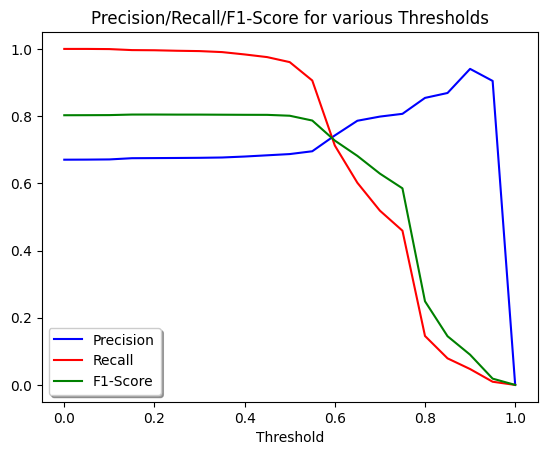

In [119]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set threshold from 0.0 to 1.0 in 0.05 increments
thresh_list = np.arange(0, 1.05, 0.05).tolist()

P_list = []
R_list = []
F1_list = []

# Calculate P and R for each threshold
for thresh in thresh_list:
    # Get predictions from the model on the test set, these are probabilities
    pred_baseline = baseline_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # Need to convert these probabilities into predictions based on the threshold
    y_hat_pred = (pred_baseline > thresh).astype("int32")  # Snap to binary class labels based on threshold

    # Add the metrics to the proper lists
    P_list.append(precision_score(y_test, y_hat_pred))
    R_list.append(recall_score(y_test, y_hat_pred))
    F1_list.append(f1_score(y_test, y_hat_pred))

# Now plot P and R
plt.plot(thresh_list, P_list, color='b', label="Precision")
plt.plot(thresh_list, R_list, color='r', label="Recall")
plt.plot(thresh_list, F1_list, color='g', label="F1-Score")
plt.xlabel('Threshold')
plt.title('Precision/Recall/F1-Score for various Thresholds')
plt.legend(loc='best', shadow=True)

print(f"\nBest F1-Score to beat is {F1_list[np.argmax(F1_list)]} with threshold {thresh_list[np.argmax(F1_list)]}.")

From the graph above, we can see that if the threshold is set to 0, our classifier labels everything as malware.  Therefore it makes sense that the Recall is 1.0 or perfect, because we *do* perfectly classify all malware.  However, in this case Precision is low, meaning, of the things we predict to be malware, our accuracy is low.  It makes sense that Precision is about 0.666 in this case, because of the skewed data, about 1/3 of our predictions on the positive class are wrong.

Similarly, if the threshold is set very high, then nothing is predicted as malware.  We essentially never predict the positive class.  Precision will be very high because we are saying, "only predict malware if you are EXTREMELY confident (high probability)."  So the precision is good, but almost nothing is that confident, so most positive class don't get labeled as malware and Recall is very low.  

> 📝 *Note that precision drops off a cliff when the threshold actually reaches 1.0, since the numerator becomes 0.  From the graph, it looks like the last datapoint where the numerator is just 1 data point is where probability/confidence is about 0.95.*

But we have to find a balance.  I mean, the *safest* thing is to set the threshold so low on prediction that everything gets flagged as malicious.  Then nothing gets through, but we're flagging so much that we're annoying all our users and our virus-scanner is useless.  

It's easier to compare classifier performance if we have a single metric to look at, instead of two.  If we look at the F1-Score instead, which is the harmonic mean of Precision and Recall, we can have a single metric to evaluate models on.  The chart plots F1-Score as well, and we can see that a threshold of 0.5 actually looks like probably the best threshold, for this learning algorithm anyway, as it's about the highest F1-Score before the Recall falls off the cliff.

However, this performance is inadequate.  Even setting the threshold to 0.5, we might as well set it to 0.  Both the Precision, Recall, and F1-Score are about the same up to that point.  Basically we are unable to learn anything statistically relevant, versus random guessing proportional to the data in the dataset!  If we guess malware 2 out of every 3 guesses randomly, we'll perform as well as our trained model.

<mark>Perhaps it is just not possible to predict malware based on permissions alone?</mark>  Is this a fundamental limitation of our data, or is this limited by our neural network's capacity?

Let's see if we can do better than an F1-Score of 0.803 using other architectures.

# Decision Trees and Random Forests

We'll try using decision trees and random forests for this dataset instead, since decision trees (and by extension, random forests) don't have a problem with imbalanced datasets.  The other main benefit of decision trees is they offer better **explainability**, by showing us which features are most relevant to the classification decision.

There are some differences we'll need to keep in mind when working with these instead of neural networks, since there are some major differences.  In general, decision trees are a lot easier to deal with than our diva neural networks!

- We don't need a validation dataset.  Decision trees only read over the data once to train, so there is no concept of early stopping or detecting overfitting. (⚠ We will need a validation set later again when we use a tuner to search the solution space).
- Since we only iterate over the data once, think of this like epochs=1
- Datasets do not need to be shuffled (though we already did this earlier and it doesn't hurt)
- There is no concept of a batch size.  All the data must fit into memory.  Doing a quick rule of thumb, if each entry is a 32-bit value (4 bytes), then we have roughly 30K examples, across ~50 features, which would be only 6MB (easy-peasy here, just one thing to keep in mind when training decision trees).
- Decision trees can consume data as numeric or even categorical strings.  No pre-processing to numbers is necessary.  Here we already have exclusively binary features.
- The labels *are* expected to be integers, but we've already made it so for the neural network case.
- Decision trees do not need features to be normalized or standardized, since the data is simply split on features there is no numerical stability issue.

We'll use Tensorflow Decision Forests library for this task.  When using this, we also don't specify a loss function (as we're not doing gradient descent).  Instead we simply specify a task instead, such as Classification in this case.  Currently, TFDF library also does not support GPU, but random forests tend to train much faster anyway even on a CPU.

## Prepare the Data for Decision Forests Library

As mentioned, we don't need a separate validation dataset, so let's merge these back.

In [120]:
print(f"X_train: {X_train.shape} of type {type(X_train)}")
print(f"y_train: {y_train.shape} of type {type(y_train)}\n")

print(f"X_val: {X_val.shape} of type {type(X_val)}")
print(f"y_val: {y_val.shape} of type {type(y_val)}\n")

print("Combining train and val datasets since separate val dataset not needed for decision trees.\n")

# Concatenate train and val datasets
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

print(f"X_train: {X_train.shape} of type {type(X_train)}")
print(f"y_train: {y_train.shape} of type {type(y_train)}\n")

X_train: (23999, 51) of type <class 'pandas.core.frame.DataFrame'>
y_train: (23999,) of type <class 'numpy.ndarray'>

X_val: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_val: (3000,) of type <class 'numpy.ndarray'>

Combining train and val datasets since separate val dataset not needed for decision trees.

X_train: (26999, 51) of type <class 'numpy.ndarray'>
y_train: (26999,) of type <class 'numpy.ndarray'>



## Random Forest Model

In [121]:
import tensorflow_decision_forests as tfdf

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.12.0


In [122]:
# The loss is automatically determined from the task.
rf_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION, verbose=2)

# Optional if you want to report other than the accuracy.
# TFDF models work better with basic metrics, so use simple ones instead
rf_model.compile(metrics=['accuracy'])  # Use basic accuracy instead of custom metrics

Use 2 thread(s) for training
Use /tmp/tmp91wy8cop as temporary training directory


In [123]:
# Fit the model
rf_model.fit(X_train, y_train, verbose=1)

Reading training dataset...
Training dataset read in 0:00:00.902656. Found 26999 examples.
Training model...
Model trained in 0:00:33.160320
Compiling model...
Model compiled.


In [124]:
# Evaluate the model
rf_eval = rf_model.evaluate(X_test, y_test, return_dict=True)

for name, value in rf_eval.items():
  print(f"{name}: {value:.4f}")

94/94 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6793
loss: 0.0000
accuracy: 0.6793


Comparing this to the Neural Network models, which as a reminder had Precision = 0.685, Recall = 0.971, and F1-Score of 0.803.

This out-of-the-box decision tree gave us Precision = 0.684, Recall = 0.972, and F1-Score of 0.802 `(harmonic mean = 2/((1/0.684)+(1/0.972)))`, and so we're about perfectly equal to the neural networks, with no optimizations yet.

## Variable Importance

One cool thing about random-forest-based architectures, is they offer better explainability than neural networks.  Or at least, it's easier to find what variables are important to the model.  

We can get these important features from a Tensorflow inspector object, but when we converted the dataset from Pandas to NumPy arrays, we lost the feature names.  Let's get those back now so they are actually humanly meaningful.

### Restore Feature Names

In [125]:
# When we converted Pandas to NumPy on dataset, we lost the feature names.
# Let's get those back
feature_names = malware_pdf.iloc[0]
print(feature_names.shape)

# And drop the last column, which is the Class labels
feature_names = feature_names.drop(['Class'])  # No axis argument since just a single row
print(feature_names.shape)

# Build feature headers as a Python list
feature_headers_list = []
for col_header in feature_names.index:
    feature_headers_list.append(col_header)

# Final list is 51 elements long, features 0:50
print(feature_headers_list)

(52,)
(51,)
['Default : modify battery statistics (S)', 'Default : power device on or off (S)', 'Hardware controls : change your audio settings (D)', 'Hardware controls : control flashlight (S)', 'Hardware controls : control vibrator (S)', 'Hardware controls : record audio (D)', 'Hardware controls : take pictures and videos (D)', 'Network communication : create Bluetooth connections (D)', 'Network communication : full Internet access (D)', 'Network communication : receive data from Internet (S)', 'Network communication : view Wi-Fi state (S)', 'Network communication : view network state (S)', 'Phone calls : intercept outgoing calls (D)', 'Phone calls : modify phone state (S)', 'Phone calls : read phone state and identity (D)', 'Services that cost you money : directly call phone numbers (D)', 'Services that cost you money : send SMS messages (D)', 'Storage : modify/delete USB storage contents modify/delete SD card contents (D)', 'System tools : automatically start at boot (S)', 'System 

### Variable Importance &mdash; Bar Plot

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


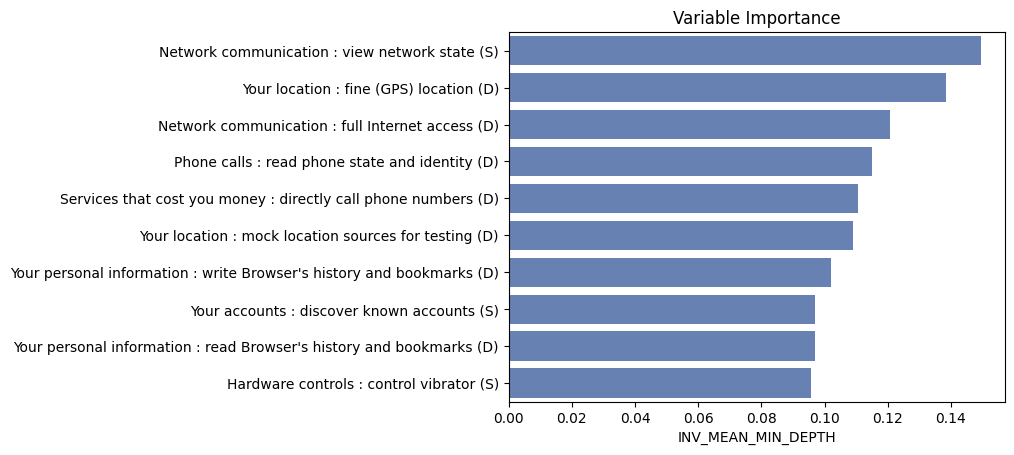

In [126]:
# Summary is way too verbose, looked once and then turned it off
# rf_model.summary()

# Instead, lets look at the feature importance
inspector = rf_model.make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

# These are the nameless version
# print(inspector.features())

# https://www.spaywall.com/news/https://towardsdatascience.com/tensorflow-decision-forests-a-comprehensive-introduction-3b6056a6d6b0
def plot_tfdf_importances(inspector, importance_type):
    """Extracts and plots TFDF importances from the given inspector object

    Args:
        inspector (tfdf.inspector.AbstractInspector): inspector object created from your TFDF model
        importance_type (str): importance type to plot
    """
    try:
        importances = inspector.variable_importances()[importance_type]
    except KeyError:
        raise ValueError(
            f"No {importance_type} importances found in the given inspector object"
        )

    names = []
    scores = []
    # Just the top 10
    for f in importances[:10]:
        # Add the actual feature names back in instead of the feature index
        # names.append(f[0].name)           # e.g. "data:0.17"
        idx = int(f[0].name.split(".")[1])  # e.g. 17
        names.append(feature_headers_list[idx])  # e.g. Network communication : create Bluetooth connections (D)'
        scores.append(f[1])

    sns.barplot(x=scores, y=names, color="#5a7dbf")
    plt.xlabel(importance_type)
    plt.title("Variable Importance")
    plt.show()

plot_tfdf_importances(inspector, "INV_MEAN_MIN_DEPTH")

### Variable Importance &mdash; Possible Explanations

Above we plotted the Top Ten most statistically important Android permissions which have predictive value over whether an app is malware or not.

Let's look at them, putting on our Red Team hat for a sec and see what havoc we can wreak 😈:
1. View network state &rarr; We need to know when your phone is online so we can download crypto workloads, and upload your keystroke logs.
2. Fine GPS location &rarr; It's nice to know where in the world you are, for social engineering and threatening intimidation.
3. Full Internet access &rarr; Jackpot!
4. Read phone state and identity &rarr; Getting your phone number, real name.
5. Directly call phone numbers &rarr; Spam people with texts from your phone number, that isn't (yet) on a blacklist.
6. Mock location sources for testing &rarr; Get around geolocation filters.
7. Write browser's history and bookmarks &rarr; Your new tab page should be my eth wallet, check it out! 😎💲💲
8. Discover known accounts &rarr; Why yes, let's login to everything with Google and Facebook kthxbye
9. Read browser's history &rarr; Good for blackmail / extortion purposes.  You visited *what* site??
10. Control vibrator &rarr; I think this is becoming less predictive right about here.  Buzz your phone 'til we kill the batteries?

## Gradient Boosted Trees

Let's try using a Gradient Boosted Tree instead of a Random Forest, based on the original 1999 paper by Jerome Friedman.  Boosted trees can improve accuracy by training sequential tree models where each tree is trained to focus on and correct the errors of the tree came before it, based on the loss gradients.

In [127]:
# Define a gradient boosted trees model
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION, verbose=2)

# Same metrics as other model - use basic metrics instead of custom ones
gbt_model.compile(metrics=['accuracy'])  # Use basic accuracy instead of custom metrics

# Googling around, the WARNINGS that come from this are OK

Use 2 thread(s) for training
Use /tmp/tmpweac8zjo as temporary training directory


In [128]:
gbt_model.fit(X_train, y_train, verbose=1)

Reading training dataset...
Training dataset read in 0:00:00.844615. Found 26999 examples.
Training model...
Model trained in 0:00:13.343831
Compiling model...
Model compiled.


In [129]:
# Evaluate the model
gbt_eval = gbt_model.evaluate(X_test, y_test, return_dict=True)

for name, value in gbt_eval.items():
  print(f"{name}: {value:.4f}")

94/94 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6797
loss: 0.0000
accuracy: 0.6797


## Architecture Comparison So Far

Let's compare everything we've used so far in a table, as it's starting to get hard to keep track.


|           | Neural Networks | Random Forest | Gradient Boosted Trees |
|-----------|-----------------|---------------|------------------------|
| Precision | 0.685           | 0.684         | 0.685                  |
| Recall    | 0.971           | 0.972         | 0.965                  |
| F1-Score  | 0.803           | 0.802         | 0.801                  |

We can see that the Gradient Boosted Trees performed about the same as the Random Forest (going by F1-Score), and very similar to Neural Networks.  It's starting to look like our ceiling on performance is due to a limitation of the data and not architecture, but let's keep trying a few more things.

We just used the default settings.  Let's see if we can get better performance from the GBT by playing with some hyperparameters.

### Hyperparameter Templates

The Tensorflow Decision Forests library has added templates of hyper-parameters that have proven well as better default settings from Google's internal testing against hundreds of datasets.  They made these template options so that they never change the "default" settings and don't break any existing codebases.

This is the easiest way to try to gain some performance, so let's try it.

In [130]:
# Added the "best" hyperparameters, and boosted tree count from 300 (default) to 500
gbt_model_hyperptemplate = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    hyperparameter_template="benchmark_rank1",
    task=tfdf.keras.Task.CLASSIFICATION,
    verbose=2
)

# Same metrics as other model - use basic metrics instead of custom ones
gbt_model_hyperptemplate.compile(metrics=['accuracy'])  # Use basic accuracy instead of custom metrics

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use 2 thread(s) for training
Use /tmp/tmpfh7w_jib as temporary training directory


In [131]:
gbt_model_hyperptemplate.fit(X_train, y_train, verbose=1)

Reading training dataset...
Training dataset read in 0:00:00.831296. Found 26999 examples.
Training model...
Model trained in 0:00:21.429290
Compiling model...
Model compiled.


In [132]:
# Evaluate the model
gbt_model_hyperptemplate_eval = gbt_model_hyperptemplate.evaluate(X_test, y_test, return_dict=True)

for name, value in gbt_model_hyperptemplate_eval.items():
  print(f"{name}: {value:.4f}")

94/94 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6827
loss: 0.0000
accuracy: 0.6827


Only very slightly better than the normal GBT.

|           | Neural Networks | Random Forest | Gradient Boosted Trees | GBT (hyperparameter template) |
|-----------|-----------------|---------------|------------------------|-------------------------------|
| Precision | 0.685           | 0.684         | 0.685                  | 0.686                         |
| Recall    | 0.971           | 0.972         | 0.965                  | 0.964                         |
| F1-Score  | 0.803           | 0.802         | 0.801                  | 0.802                         |

Let's look at the new confusion matrix.

94/94 [==============================] - 0s 2ms/step
Legitimate Benign Apps Detected (True Negatives):  115
Legitimate Benign Apps Incorrectly Detected (False Positives):  874
Malicious Apps Missed (False Negatives):  78
Malicious Apps Detected (True Positives):  1933
Total Malicious Apps:  2011


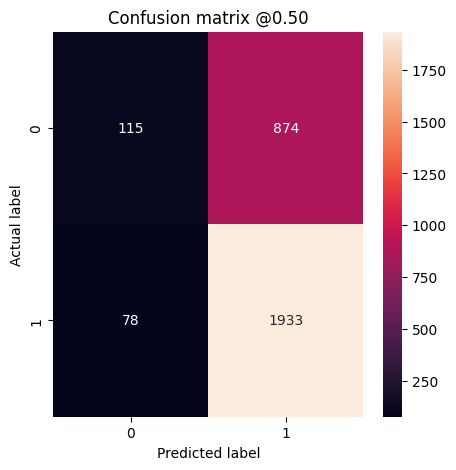

In [133]:
gbt_hyp_test_predictions = gbt_model_hyperptemplate.predict(X_test)

plot_cm(y_test, gbt_hyp_test_predictions)

### Automatic Hyperparameter Tuning

This was using Google's template hyperparameters found on their datasets, but we can also perform hyperparameter tuning on our dataset.  This will sweep the hyperparameters and find the best model automatically.  As you can imagine, the training time to explore this solution space explodes exponentially as with any combinatorics problem.  This is handled by setting a max number of trials, and the search space is chosen randomly within that limit of total trials.

The TFDF tuner offers both manual and automated tuning approaches.  In the manual approach, you specify the parameters you want to sweep and their ranges. In automatic mode, it automatically chooses what variables to tune.  This is easiest, and often gives the best results.  However, it takes the longest for large datasets.  

Even for our case with a smaller dataset, this took a very long time.  About 6 hours!  (It's been disabled now).

### Re-split the Data to Train/Val/Test Sets

For the tuning algorithm to have a test set to evaluate results on, without "peeking" at the test set, we are going to need our validation set back.  If we didn't do this, then the tuner would have to evaluate how it's doing by looking at the test set, which is a form of data leakage and would make the tuner tend to overfit to the test set.

In [134]:
# NOTE: Don't need to standardize/normalize the features, they're all already on the same small scale

# Split the data again.  We already have X_train / y_train
# We want 10% of the ORIGINAL size, which is equivalent to 11.111% of the X_train size
# i.e. 3000 = 11.111% of 26999
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=42)        # 10% ends up in val set

# Confirm sizes and types.  Note that all X are converted to NumPy ndarrays!
print(f"X_train: {X_train.shape} of type {type(X_train)}")
print(f"y_train: {y_train.shape} of type {type(y_train)}\n")

print(f"X_val: {X_val.shape} of type {type(X_val)}")
print(f"y_val: {y_val.shape} of type {type(y_val)}\n")

print(f"X_test: {X_test.shape} of type {type(X_test)}")
print(f"y_test: {y_test.shape} of type {type(y_test)}\n")

X_train: (23999, 51) of type <class 'numpy.ndarray'>
y_train: (23999,) of type <class 'numpy.ndarray'>

X_val: (3000, 51) of type <class 'numpy.ndarray'>
y_val: (3000,) of type <class 'numpy.ndarray'>

X_test: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_test: (3000,) of type <class 'numpy.ndarray'>



### Define the Tuner (Manual or Automatic)

In [135]:
# If you want to Manually define the search space..
# tuner = tfdf.tuner.RandomSearch(num_trials=50)
# tuner.choice("min_examples", [2, 5, 7, 10])
# tuner.choice("categorical_algorithm", ["CART", "RANDOM"])
# tuner.choice("max_depth", [3, 4, 5, 6, 8])
# tuner.choice("use_hessian_gain", [True, False])
# tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
# tuner.choice("growing_strategy", ["LOCAL"]).choice("max_depth", [3, 4, 5, 6, 8])
# tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True).choice("max_num_nodes", [16, 32, 64, 128, 256])
# # ... Add all the parameters to tune

# # Note the tuner=tuner argument!
# model = tfdf.keras.GradientBoostedTreesModel(verbose=2, tuner=tuner)
# model.fit(training_dataset)

# Instead, we'll do all this automatically, including selecting which hyperparameters to tune
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# No need to configure each hyper-parameter

# Define and train a GBT model.  NOTE: tuner=tuner to make it auto-tune!
gbt_tuned_model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION, verbose=2, tuner=tuner)
gbt_tuned_model.compile(metrics=['accuracy'])  # Use basic accuracy instead of custom metrics

Use 2 thread(s) for training
Use /tmp/tmp776uw2j9 as temporary training directory


### Fit the Automatic Hyperparameter Tuner

> 📝 **NOTE:** I disabled the following tuning code.  It runs for about 6 hours, and doesn't produce any better results than what we already have.  Leaving this code here as a reference.

In [136]:
# Now Fit!  NOTE: the validation data is needed to be listed explicitly since not using a TFDS type for our data

# NOTE: This runs for like 6 hours!  Disabled after running the first time and finding no improvements.
# gbt_tuned_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0)

In [137]:
# # Evaluate the model (already compiled it)
# tuned_eval = gbt_tuned_model.evaluate(X_test, y_test, return_dict=True)

# for name, value in tuned_eval.items():
#   print(f"{name}: {value:.4f}")

In [138]:
# # Display the tuning logs.
# tuning_logs = gbt_tuned_model.make_inspector().tuning_logs()
# tuning_logs.head()

In [139]:
# # Show the best hyper-parameters
# tuning_logs[tuning_logs.best].iloc[0]

In [140]:
# # Finally, plot the progress of the quality of the model during the random search space tuning
# plt.figure(figsize=(10, 5))
# plt.plot(tuning_logs["score"], label="current trial")
# plt.plot(tuning_logs["score"].cummax(), label="best trial")
# plt.xlabel("Tuning step")
# plt.ylabel("Tuning score")
# plt.legend()
# plt.show()

### Automated HyperParameter Tuning Results

After running for about 6 hours, the final result was no better than we already had, with a Precision of 0.691, a Recall of 0.952, and a total F1-Score of 0.800.  Commented out from future runs.

# Conclusion

Although we were able to get slightly better performance with Neural Networks, the performance is so close that **I recommend we use the basic Random Forest.**  Fancier options, like gradient boosted trees, hyperparameter templates, or automated hyperparameter tuning didn't lead to any improvements, and those are more complex models.  The Random Forest is simple and all the tree-based models offer better explainability of what features are most important (versus the Neural Network).

I think the reason none of these models were able to beat each other is we've fundamentally saturated performance because there is no additional predictive information to glean out of the data.  Some datasets just can't be learned.  For example, if I said we were going to try to predict malware based on the name alone of the app.. even if we had MILLIONS of datapoints and the most powerful algorithms on the planet, the app title is just not predictive enough on its own.  

Since our data is skewed in a 2:1 ratio, we could achieve a 0.66% accurate classifier by just randomly guessing `malware` two thirds of the time.  <mark>All of our models are only able to achieve an accuracy of about 0.68% &mdash; basically no better than this random guess.</mark>  In other words, I don't think permissions alone is predictive enough.  My hypothesis for this is, permissions alone don't necessitate "badness."  My app might need access to the internet, and access to your microphone, because maybe it's taking your narrations and uploading them to the cloud.  This could be benign, nay, very useful even.  But also an app that tries to eavesdrop on you and upload your private communications to a hacker-controlled server would have the exact same "permissions signature."

Additionally, iPhones and Android phones offer these features because, in theory, they are all helpful.  There isn't an "encrypt all your files" API call, for example, and so just having more of these permissions doesn't necessarily correlate with "badness."

As a sort of double-check, I found another notebook on Kaggle using this same dataset.  While our best model has an F1-Score of about 0.802, theirs achieved an F1-Score of 0.820, which is a little better, though not much.  However, they also included some of the extra data we dropped, including the user ratings.  Of course, this extra data would have some predictive value, especially user ratings, because presumably users would rate the app very low if it ends up being malware or at least not beneficial.  I decided to drop that data because I wanted to see if it could be done purely on permissions.  So clearly the answer to that question is "no."

While that feels a bit unsatisfying, one of my research professors in grad school once told me: "Science and engineering is littered with experiments that didn't work!  That is OK, it's just as valuable to know what *doesn't* work as what does as long as we can learn from it."  😎

## One last thing..

<div class="alert alert-info">
    If you’ve enjoyed following along with me or have learned something new, ☝ <b>please consider UPVOTING this notebook!</b> 🔼 It helps others discover my notebook and encourages me to spend my time writing more of these.  Thank you!  😊
</div>

💡 **You might also enjoy these other notebooks of mine as well:**

**Natural Language Processing**
* [Generate Amazon Book Reviews with Transformers](https://www.kaggle.com/code/quackaddict7/generate-amazon-book-reviews-with-transformers/)  
* [Write Your Own CliffNotes (Book Text Summarizer)](https://www.kaggle.com/code/quackaddict7/write-your-own-cliffnotes-book-text-summarizer/)  
* [Answering Questions from Product Reviews](https://www.kaggle.com/code/quackaddict7/answering-questions-from-product-reviews/)  
* [Ingredient Standardization via Machine Translation](https://www.kaggle.com/code/quackaddict7/ingredient-standardization-via-machine-translation/)  
* [What Kaggle WON'T Tell You About Your Notebooks](https://www.kaggle.com/code/quackaddict7/what-kaggle-won-t-tell-you-about-your-notebooks/)  

**Computer Vision**
* [Enhance, enhance, enhance! (image upscaling)](https://www.kaggle.com/code/quackaddict7/enhance-enhance-enhance-image-upscaling)  
* [Detecting Vehicles in Traffic (Object Detection)](https://www.kaggle.com/code/quackaddict7/object-detection-detecting-vehicles-in-traffic/)  
* [Legions of Lesions (Detecting Skin Cancer with Computer Vision)](https://www.kaggle.com/code/quackaddict7/legions-of-lesions-detecting-skin-cancer-with-cv/)  
* [Creating Synthetic Wildfire Images with Unreal Engine (Blog Post)](https://joelwigton.com/synthetic-data-for-machine-learning-with-unreal-engine)  
* [How I scored Top 5% on MNIST (without cheating!)](https://www.kaggle.com/code/quackaddict7/how-i-scored-top-5-on-mnist-without-cheating/)  

**Machine Learning**
* [Detecting Android Malware from App Permissions](https://www.kaggle.com/code/quackaddict7/detecting-android-malware-from-app-permissions/)